# MRI Brain Tumor Classification

### 1. Import libraries

In [16]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score
#---------------------------------------
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adamax
from keras.metrics import Precision, Recall
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")
#---------------------------------------
print(f"TensorFlow version: {tf.__version__}")
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")
print(f"GPUs detected: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.10.0
Built with CUDA: True
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 2. Preprocessing

In [17]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [18]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [19]:
tr_df = train_df('Training')

In [20]:
tr_df

,Class Path,Class
0,Training\glioma_tumor\gg (1).jpg,glioma_tumor
1,Training\glioma_tumor\gg (10).jpg,glioma_tumor
2,Training\glioma_tumor\gg (100).jpg,glioma_tumor
3,Training\glioma_tumor\gg (101).jpg,glioma_tumor
4,Training\glioma_tumor\gg (102).jpg,glioma_tumor
...,...,...
2865,Training\pituitary_tumor\p (95).jpg,pituitary_tumor
2866,Training\pituitary_tumor\p (96).jpg,pituitary_tumor
2867,Training\pituitary_tumor\p (97).jpg,pituitary_tumor
2868,Training\pituitary_tumor\p (98).jpg,pituitary_tumor


In [21]:
ts_df = test_df('Testing')

In [22]:
ts_df

,Class Path,Class
0,Testing\glioma_tumor\image(1).jpg,glioma_tumor
1,Testing\glioma_tumor\image(10).jpg,glioma_tumor
2,Testing\glioma_tumor\image(100).jpg,glioma_tumor
3,Testing\glioma_tumor\image(11).jpg,glioma_tumor
4,Testing\glioma_tumor\image(12).jpg,glioma_tumor
...,...,...
389,Testing\pituitary_tumor\image(95).jpg,pituitary_tumor
390,Testing\pituitary_tumor\image(96).jpg,pituitary_tumor
391,Testing\pituitary_tumor\image(97).jpg,pituitary_tumor
392,Testing\pituitary_tumor\image(98).jpg,pituitary_tumor


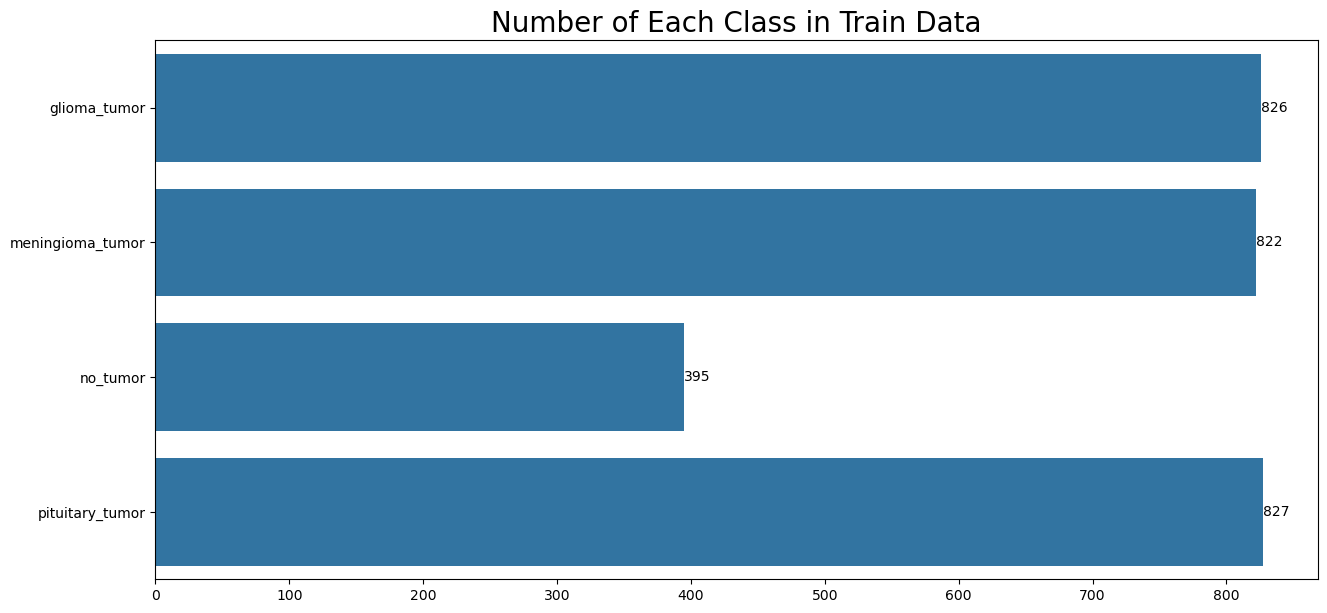

In [23]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Number of Each Class in Train Data', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

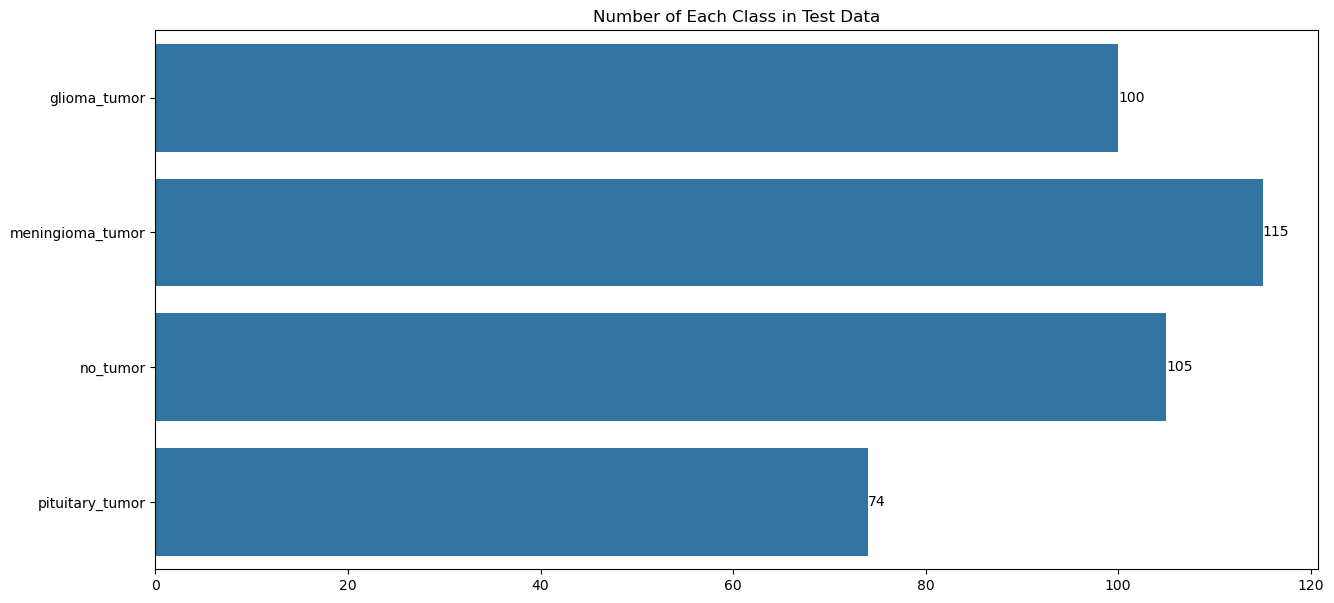

In [24]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'])

ax.set(xlabel='', ylabel='', title='Number of Each Class in Test Data')
ax.bar_label(ax.containers[0])

plt.show()

Split testing folder into validation and test sets

In [25]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [26]:
valid_df

,Class Path,Class
276,Testing\no_tumor\image(60).jpg,no_tumor
369,Testing\pituitary_tumor\image(7).jpg,pituitary_tumor
30,Testing\glioma_tumor\image(36).jpg,glioma_tumor
354,Testing\pituitary_tumor\image(53).jpg,pituitary_tumor
260,Testing\no_tumor\image(46).jpg,no_tumor
...,...,...
38,Testing\glioma_tumor\image(43).jpg,glioma_tumor
376,Testing\pituitary_tumor\image(8).jpg,pituitary_tumor
339,Testing\pituitary_tumor\image(36).jpg,pituitary_tumor
101,Testing\meningioma_tumor\image(10).jpg,meningioma_tumor


In [27]:
batch_size = 16
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 2870 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.


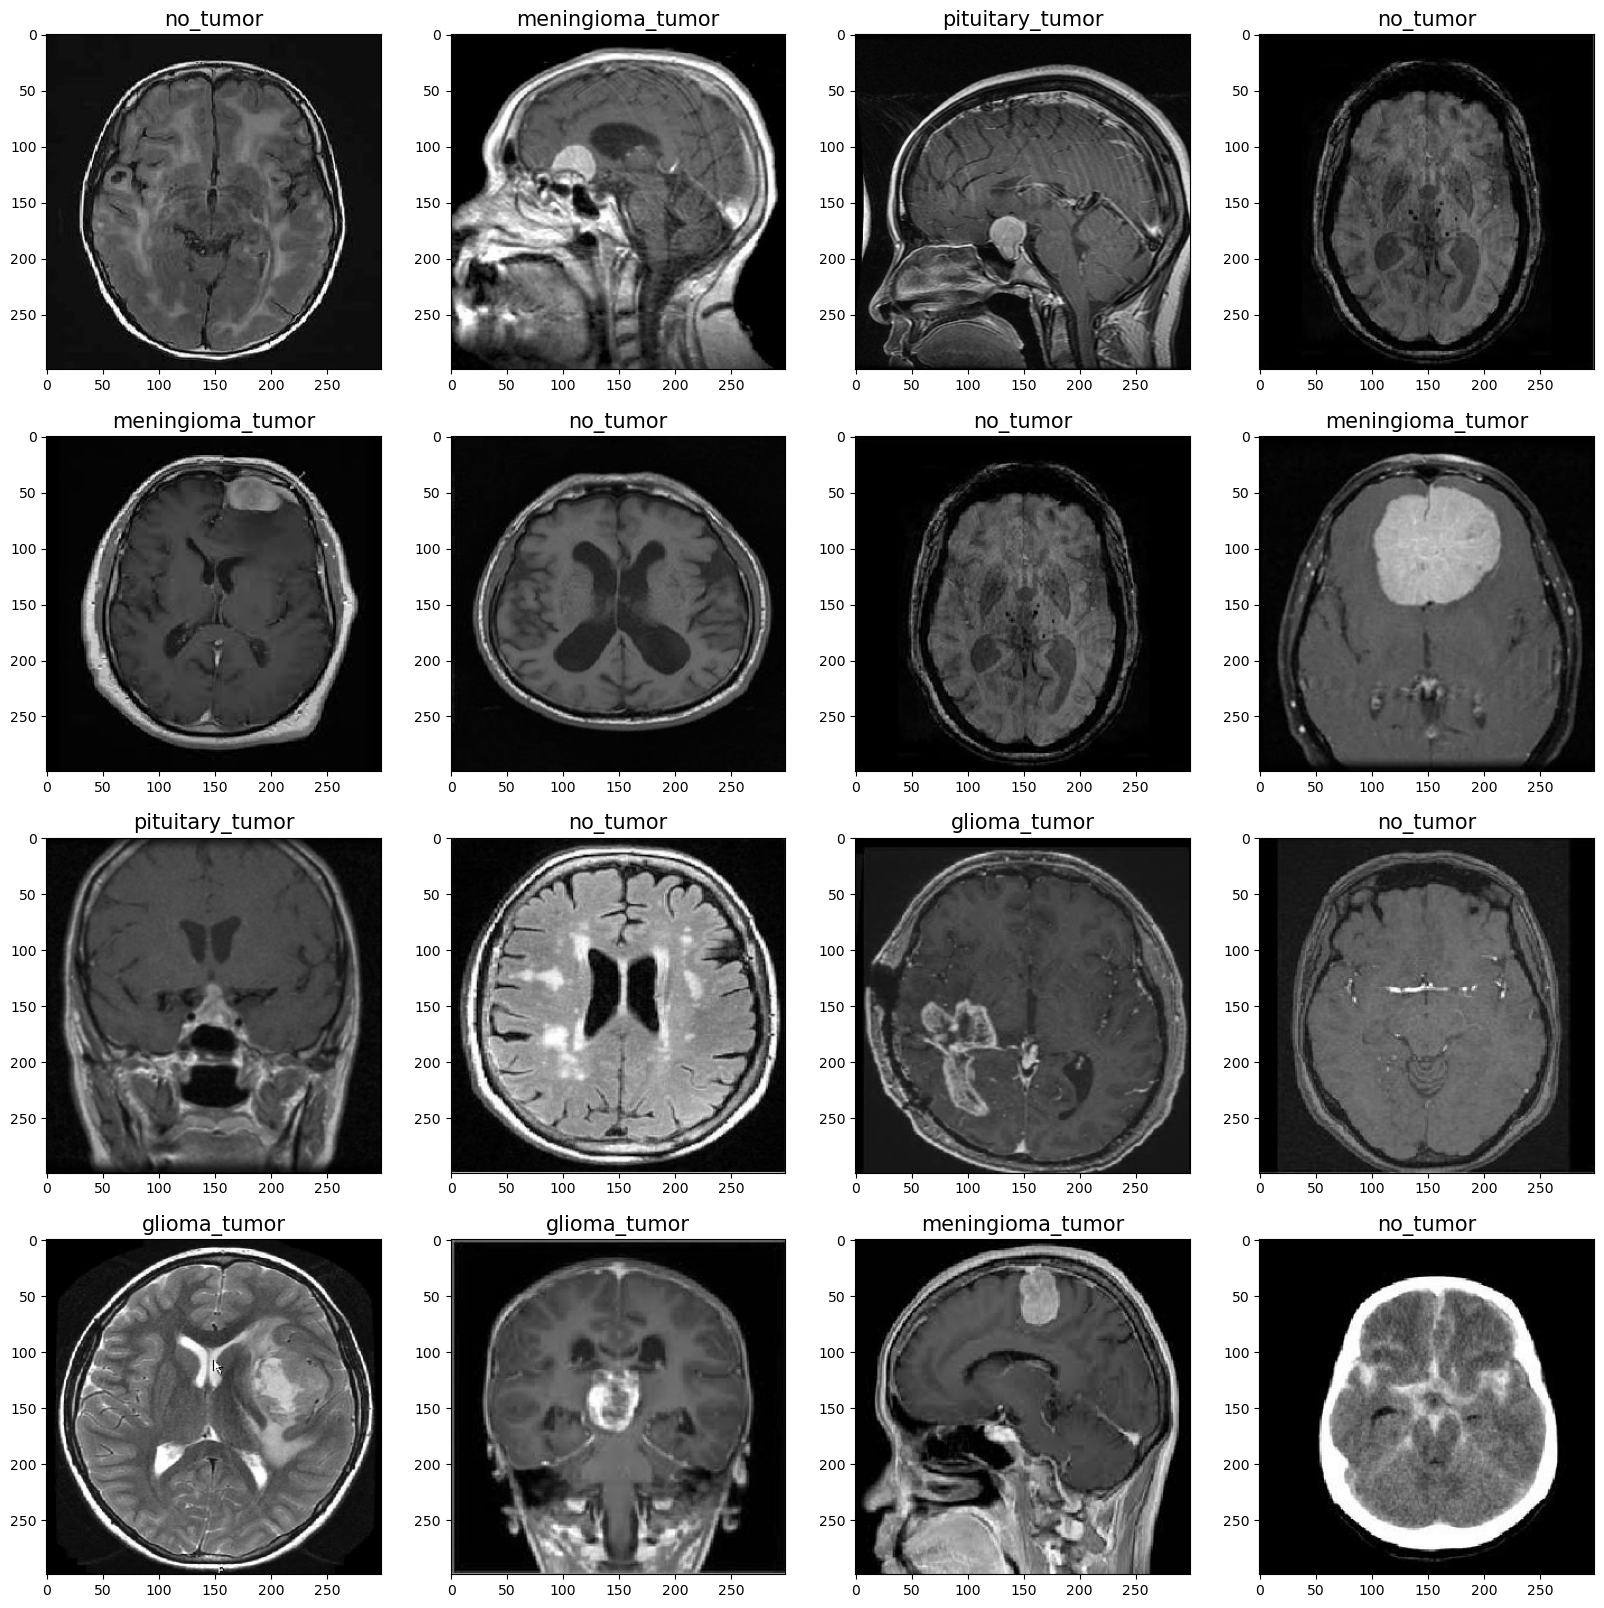

In [28]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

### Modeling

In [29]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                          Recall()])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 21,124,268
Trainable params: 21,069,740


### Training the model

In [30]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle=False)

Epoch 1/10
180/180 [==============================] - 100s 490ms/step - loss: 0.4323 - accuracy: 0.8474 - precision_1: 0.8807 - recall_1: 0.8052 - val_loss: 1.3675 - val_accuracy: 0.6802 - val_precision_1: 0.6856 - val_recall_1: 0.6751
Epoch 2/10
180/180 [==============================] - 95s 525ms/step - loss: 0.0923 - accuracy: 0.9721 - precision_1: 0.9738 - recall_1: 0.9707 - val_loss: 1.0337 - val_accuracy: 0.7919 - val_precision_1: 0.8073 - val_recall_1: 0.7868
Epoch 3/10
180/180 [==============================] - 128s 711ms/step - loss: 0.0623 - accuracy: 0.9819 - precision_1: 0.9825 - recall_1: 0.9794 - val_loss: 1.0668 - val_accuracy: 0.7868 - val_precision_1: 0.7908 - val_recall_1: 0.7868
Epoch 4/10
180/180 [==============================] - 154s 857ms/step - loss: 0.0272 - accuracy: 0.9927 - precision_1: 0.9930 - recall_1: 0.9927 - val_loss: 1.4854 - val_accuracy: 0.7919 - val_precision_1: 0.7919 - val_recall_1: 0.7919
Epoch 5/10
180/180 [==============================] - 160

In [31]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1'])

Visualization of model performance

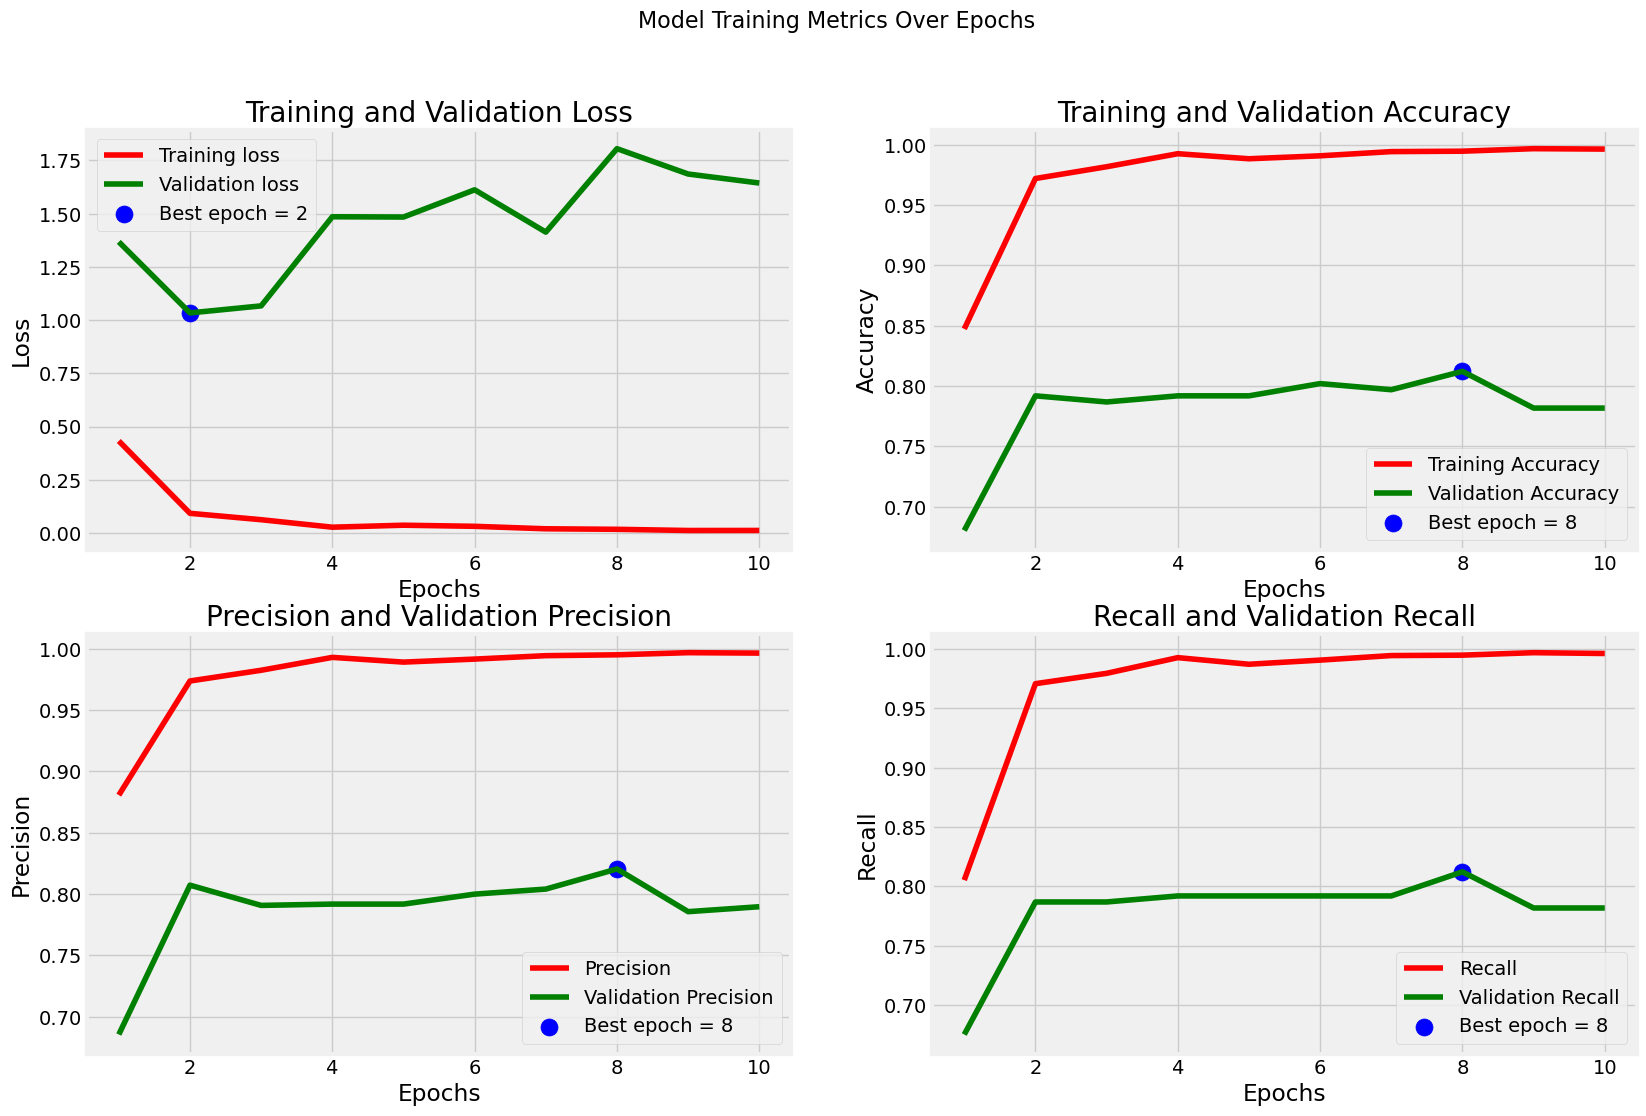

In [34]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision_1']
tr_recall = hist.history['recall_1']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision_1']
val_recall = hist.history['val_recall_1']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

### 5. Testing and Validation

In [35]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

# Get predictions for precision and F1-score calculations
print("\nGenerating predictions for metrics calculation...")
train_pred = np.argmax(model.predict(tr_gen, verbose=0), axis=1)
train_true = tr_gen.classes

valid_pred = np.argmax(model.predict(valid_gen, verbose=0), axis=1)
valid_true = valid_gen.classes

test_pred = np.argmax(model.predict(ts_gen, verbose=0), axis=1)
test_true = ts_gen.classes

# Calculate precision and F1-scores
train_precision = precision_score(train_true, train_pred, average='weighted')
train_f1 = f1_score(train_true, train_pred, average='weighted')

valid_precision = precision_score(valid_true, valid_pred, average='weighted')
valid_f1 = f1_score(valid_true, valid_pred, average='weighted')

test_precision = precision_score(test_true, test_pred, average='weighted')
test_f1 = f1_score(test_true, test_pred, average='weighted')

# Create results dataframe
results_df = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Testing'],
    'Loss': [train_score[0], valid_score[0], test_score[0]],
    'Accuracy': [train_score[1]*100, valid_score[1]*100, test_score[1]*100],
    'Precision': [train_precision*100, valid_precision*100, test_precision*100],
    'F1-Score': [train_f1*100, valid_f1*100, test_f1*100]
})

# Format the display
pd.set_option('display.precision', 2)
pd.set_option('display.width', 100)

print("\n" + "="*70)
print("MODEL PERFORMANCE SUMMARY")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

13/13 [==============================] - 3s 236ms/step - loss: 1.5682 - accuracy: 0.7970 - precision_1: 0.8093 - recall_1: 0.7970

Generating predictions for metrics calculation...

MODEL PERFORMANCE SUMMARY
   Dataset     Loss  Accuracy  Precision  F1-Score
  Training 2.52e-03     99.90      25.58     25.58
Validation 1.67e+00     77.66      20.87     20.03
   Testing 1.57e+00     79.70      85.14     77.77


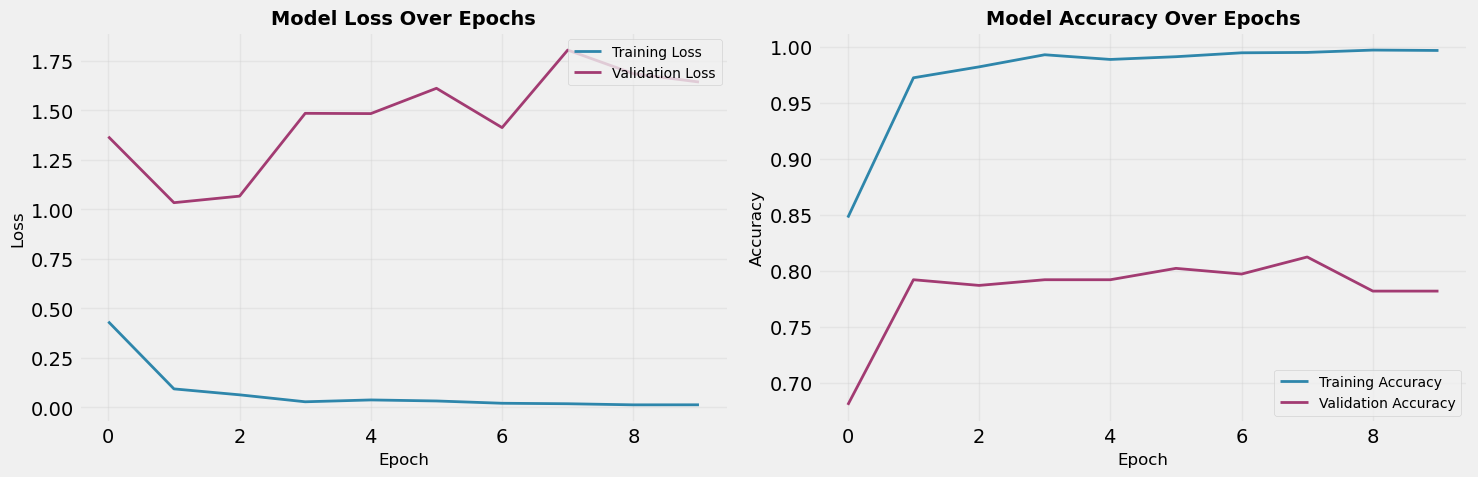

In [37]:
# train and test loss and accuracy graphs
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(hist.history['loss'], label='Training Loss', linewidth=2, color='#2E86AB')
axes[0].plot(hist.history['val_loss'], label='Validation Loss', linewidth=2, color='#A23B72')
axes[0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(hist.history['accuracy'], label='Training Accuracy', linewidth=2, color='#2E86AB')
axes[1].plot(hist.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#A23B72')
axes[1].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(loc='lower right', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [38]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

13/13 [==============================] - 2s 130ms/step


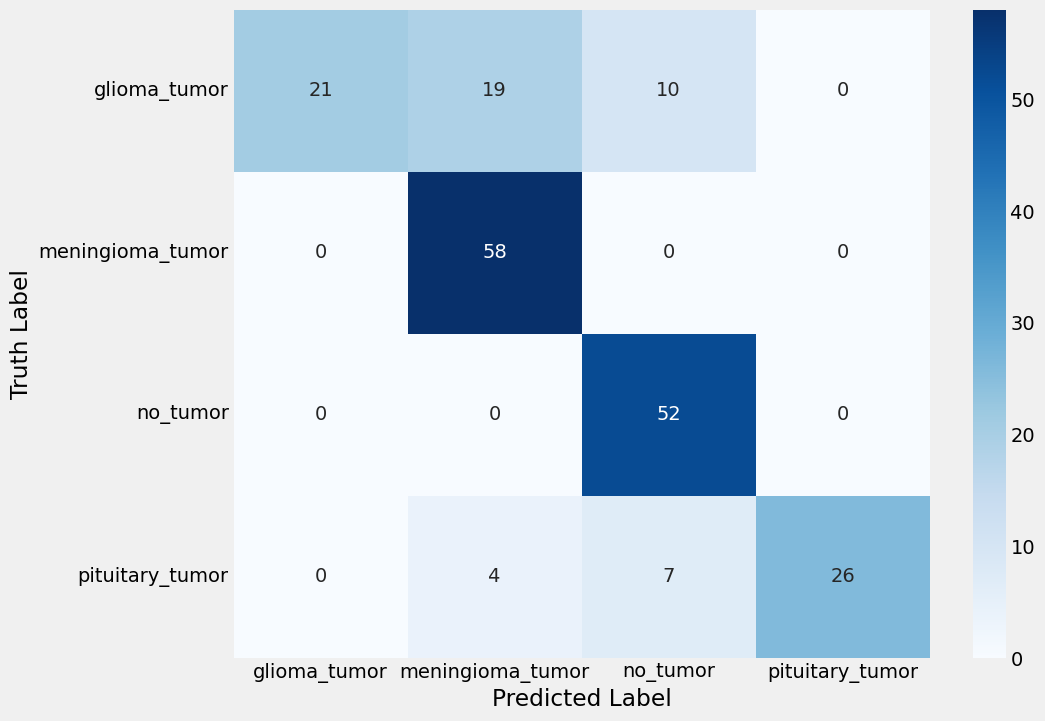

In [39]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [40]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       1.00      0.42      0.59        50
           1       0.72      1.00      0.83        58
           2       0.75      1.00      0.86        52
           3       1.00      0.70      0.83        37

    accuracy                           0.80       197
   macro avg       0.87      0.78      0.78       197
weighted avg       0.85      0.80      0.78       197



In [41]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

Testing on some of the images in our dataset...

1/1 [==============================] - 1s 1s/step


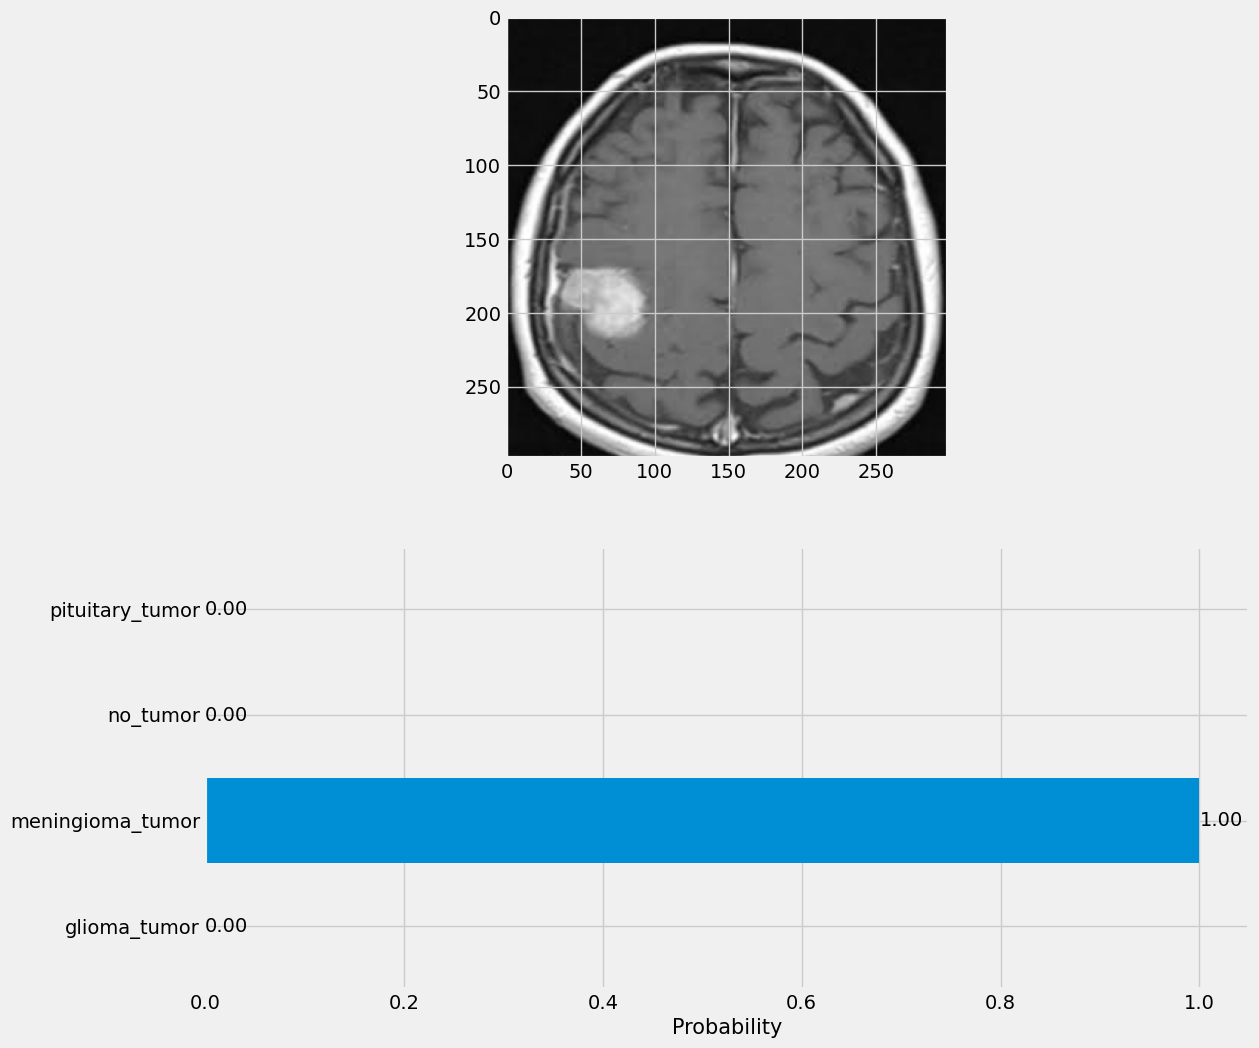

In [43]:
predict('Testing\meningioma_tumor\image(17).jpg') # Expected output: Meningioma

1/1 [==============================] - 0s 42ms/step


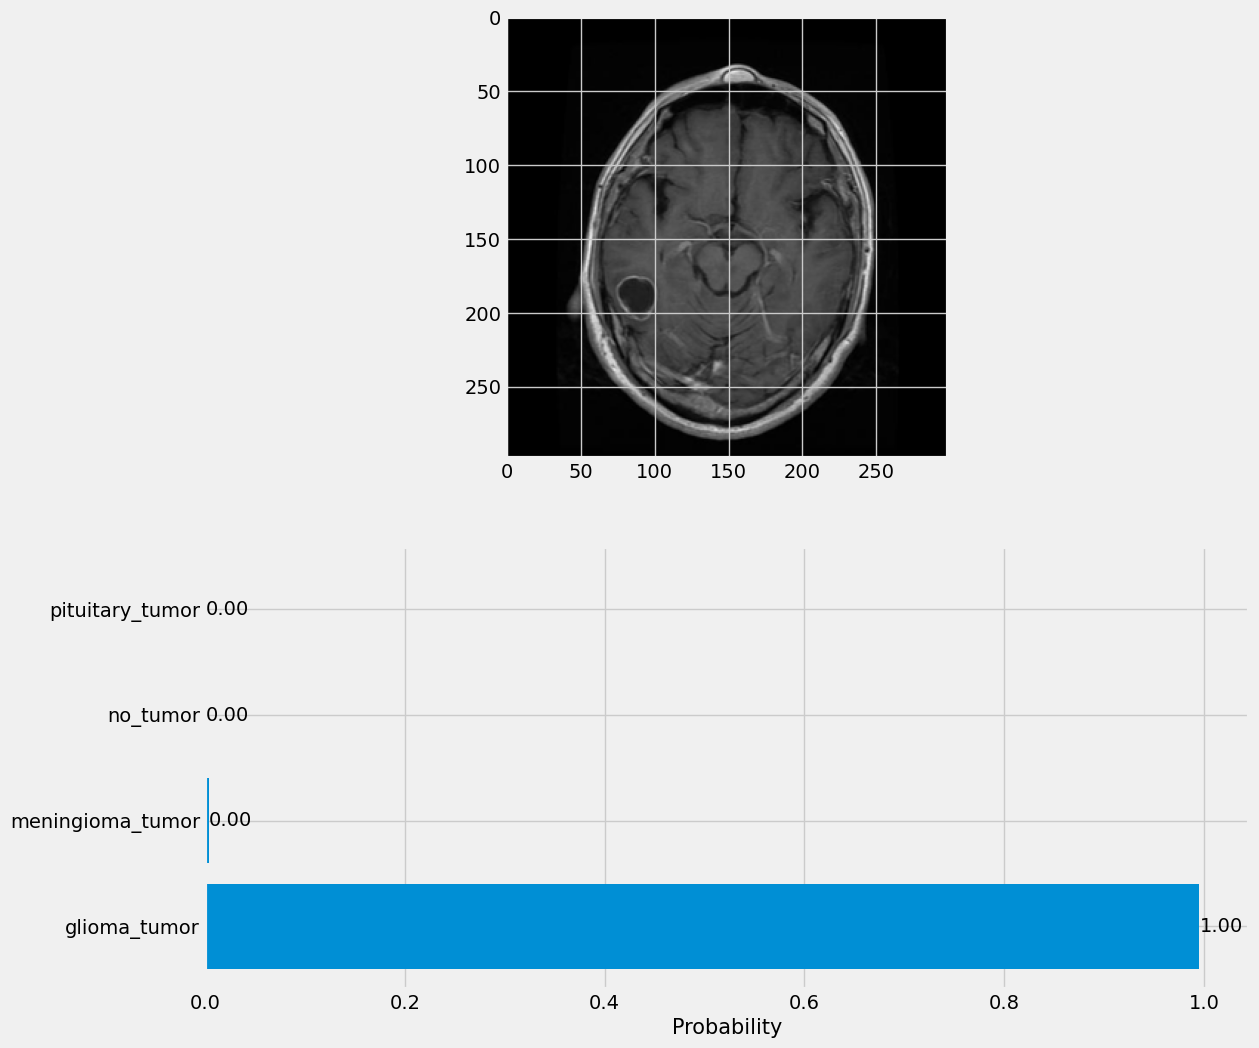

In [44]:
predict('Testing\glioma_tumor\image(76).jpg') # Expected output: Glioma


1/1 [==============================] - 0s 38ms/step


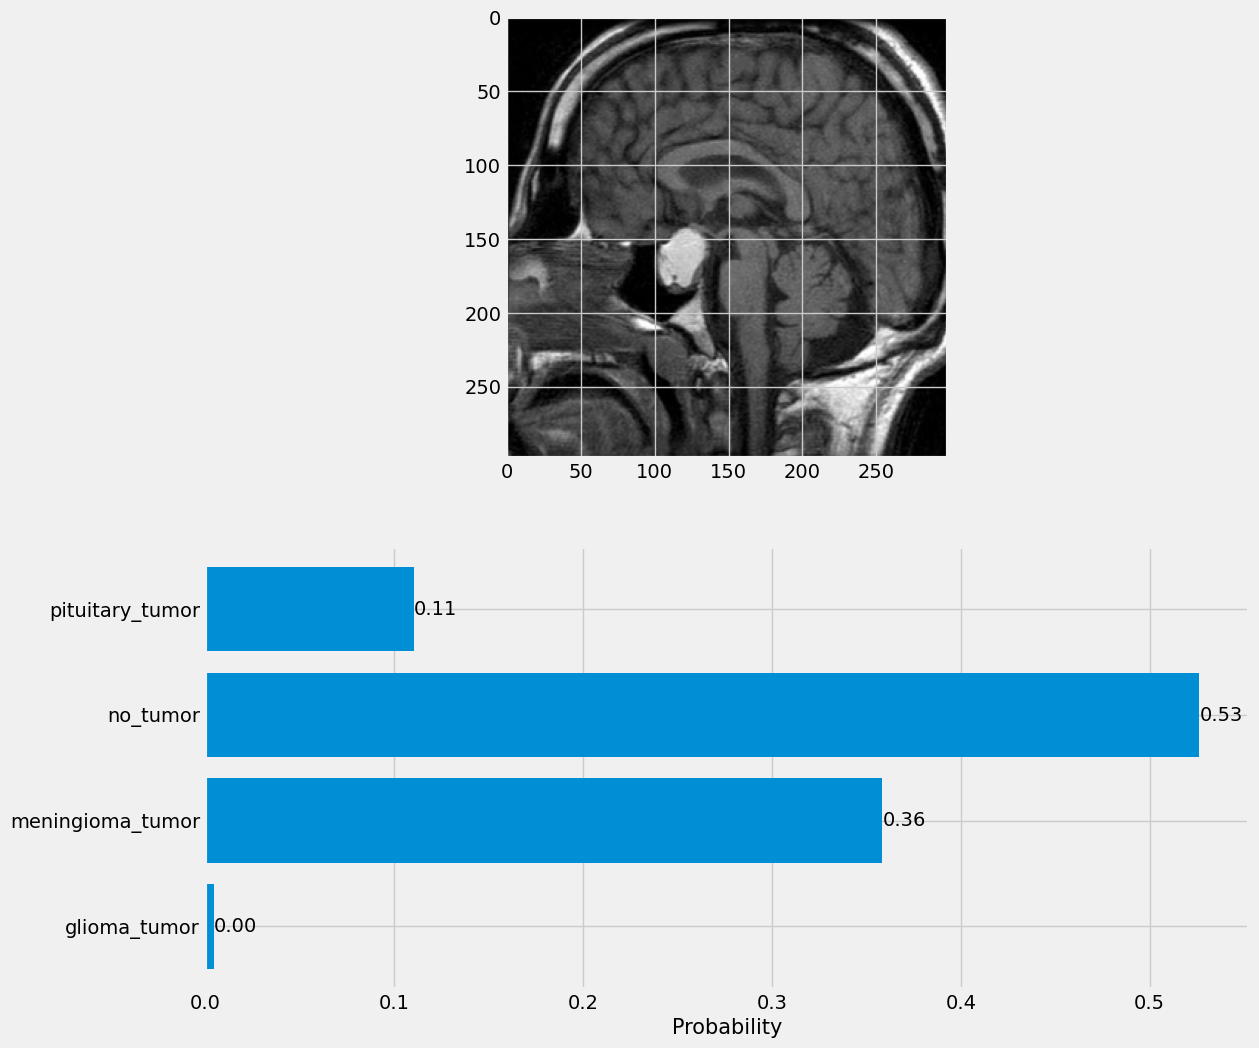

In [45]:
predict('Testing\pituitary_tumor\image(69).jpg') # Expected output: Pituitary

1/1 [==============================] - 0s 43ms/step


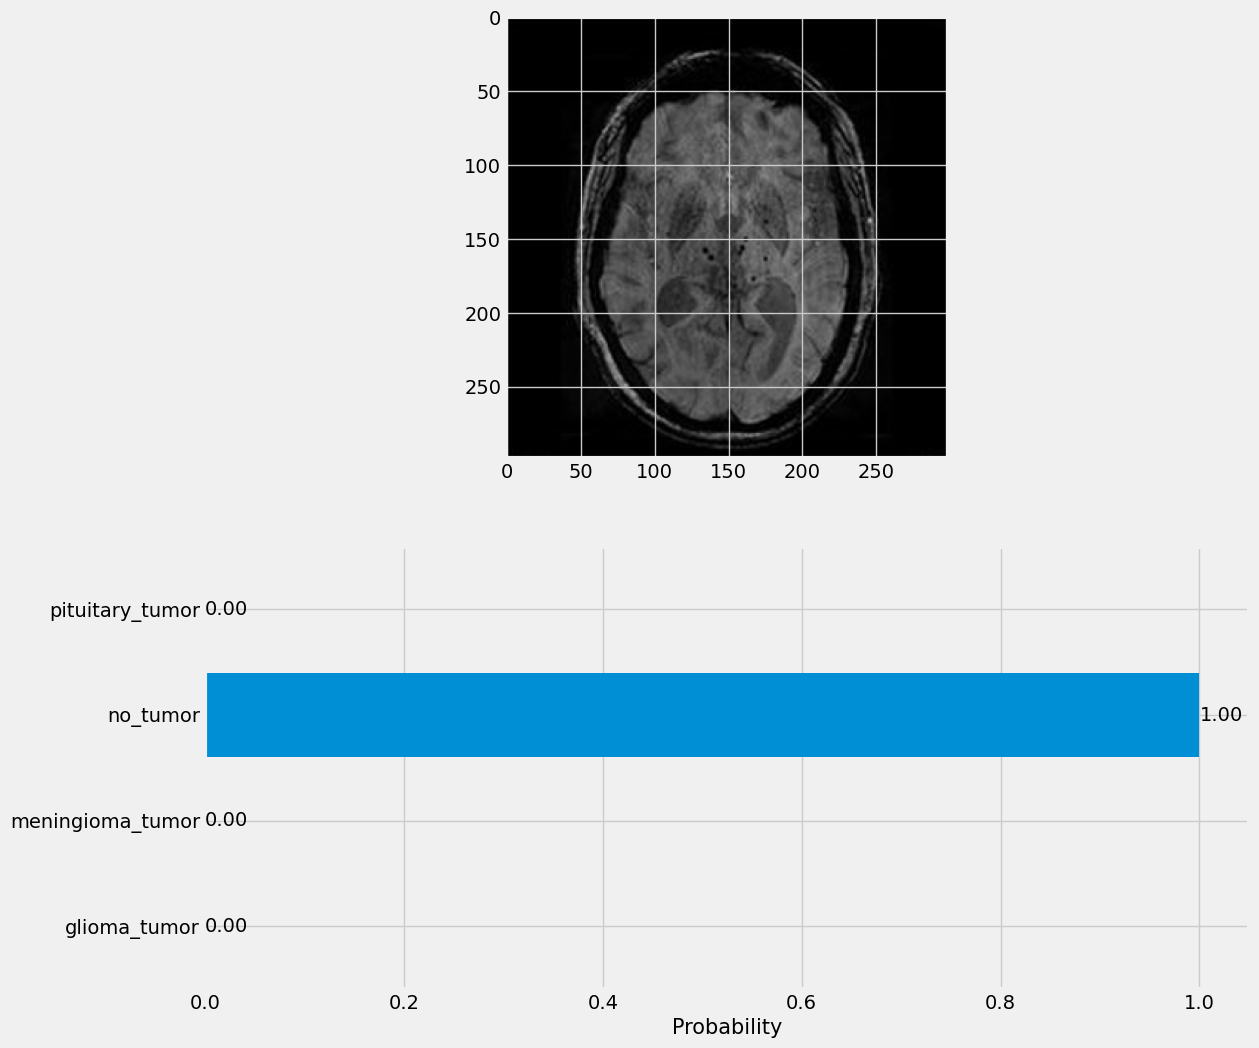

In [49]:
predict(r"Testing\no_tumor\image(6).jpg") # Expected output: No Tumor